## Import necessary libraries

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


### 1. Read the dataset and perform the necessary EDA.

Downloaded the dataset from the below link. <br>
https://drive.google.com/file/d/1NrJQbY38lNNv4iEihCK9vuww0vPoXPus/view?usp=sharing

In [21]:

path = './a10.csv'
df = pd.read_csv(path, parse_dates=['date'])

### Preview of data

In [22]:
df.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    204 non-null    datetime64[ns]
 1   value   204 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.3 KB


### checking descriptive stats

In [24]:
df.describe()

,value
count,204.000000
mean,10.694430
std,5.956998
min,2.814520
25%,5.844095
50%,9.319345
75%,14.289964
max,29.665356


### checking for NULL values

In [25]:
df.isnull().sum()

date     0
value    0
dtype: int64

__As seen above, No `null` values are present__

### Check for Duplicates

In [26]:
df.duplicated().sum()

0

__There are no duplicate values.__

### Exploratory Data Analysis

#### Scatter Plot 

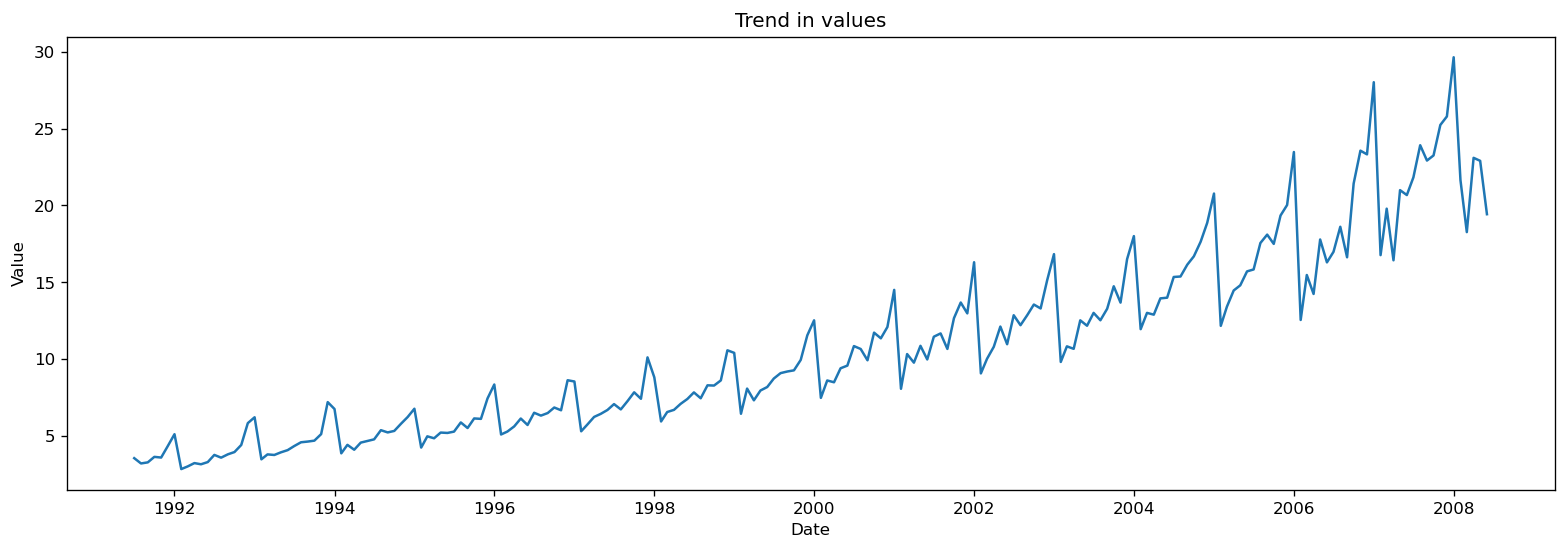

In [27]:
import matplotlib.pyplot as plt
 
# Draw Plot
def plot_data(x, y, title="", xlabel='Date', ylabel='Value', dpi=120):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
 
plot_data(x=df.date, y=df.value, title='Trend in values') 
plt.show()


#### Historgram 

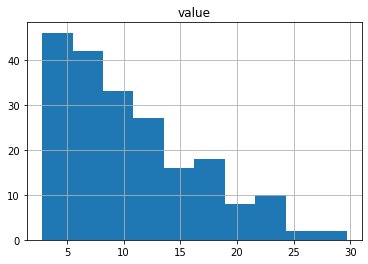

In [28]:
data = pd.read_csv('./a10.csv', parse_dates=['date'],index_col='date')
data.hist()
plt.show()


### 2. Perform ETS decomposition on the data

### Exploration

<Figure size 1920x600 with 0 Axes>

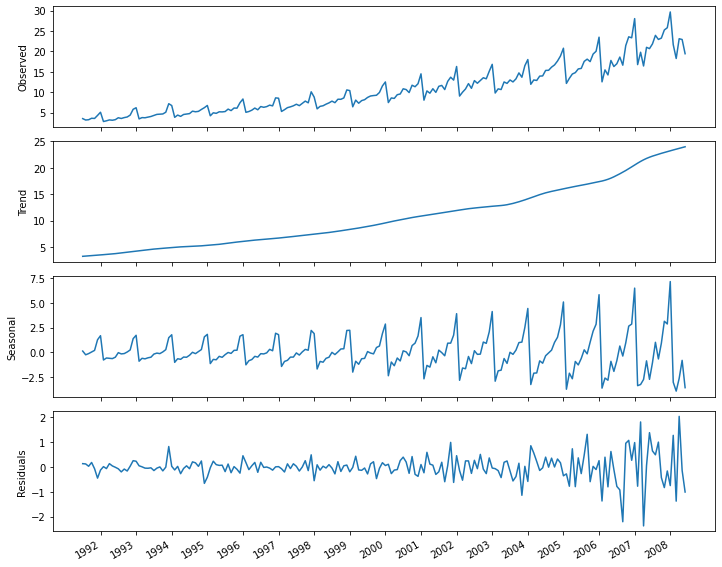

In [29]:
decomposition = STL(df.value, period=12).fit()

plt.figure(figsize=(16,5), dpi=120)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()


#### Additive and Multiplicative decompose

<Figure size 1200x500 with 0 Axes>

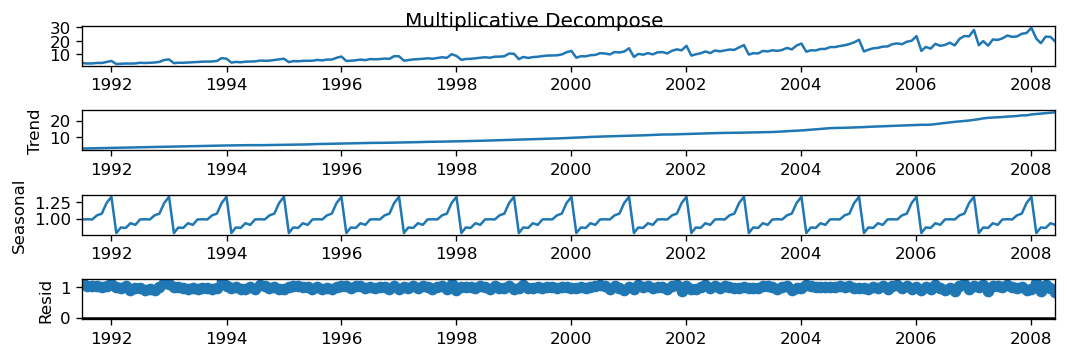

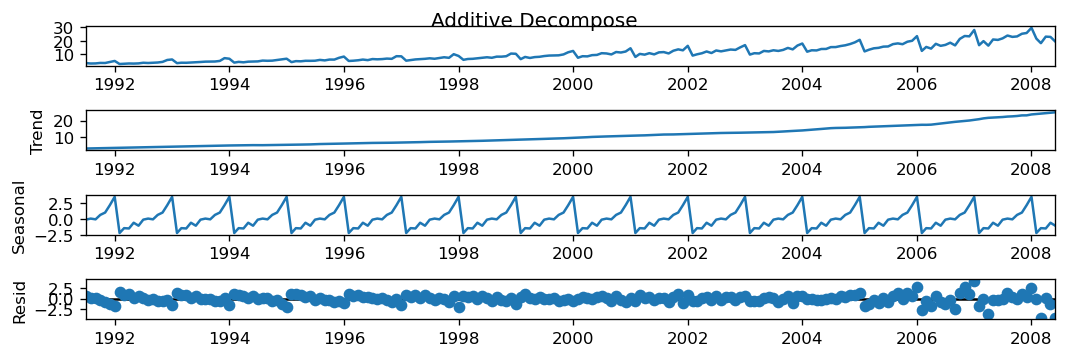

In [42]:
 
#additive decomposition
result_add = seasonal_decompose(data, model='additive',extrapolate_trend='freq')
 
#multiplicative decomposition
result_mul = seasonal_decompose(data, model='multiplicative',extrapolate_trend='freq')
 
#plot
fig = plt.figure(figsize=(12,5), dpi=100)
result_mul.plot(fig).suptitle('Multiplicative Decompose')
result_add.plot(fig).suptitle('Additive Decompose')

plt.show()

### 3. Create an ARIMA or LSTM model to forecast the data

In [31]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: 3.145186
p-value: 1.000000


### Plotting the autocorrelation function (ACF) and partial autocorrelation function (PACF)

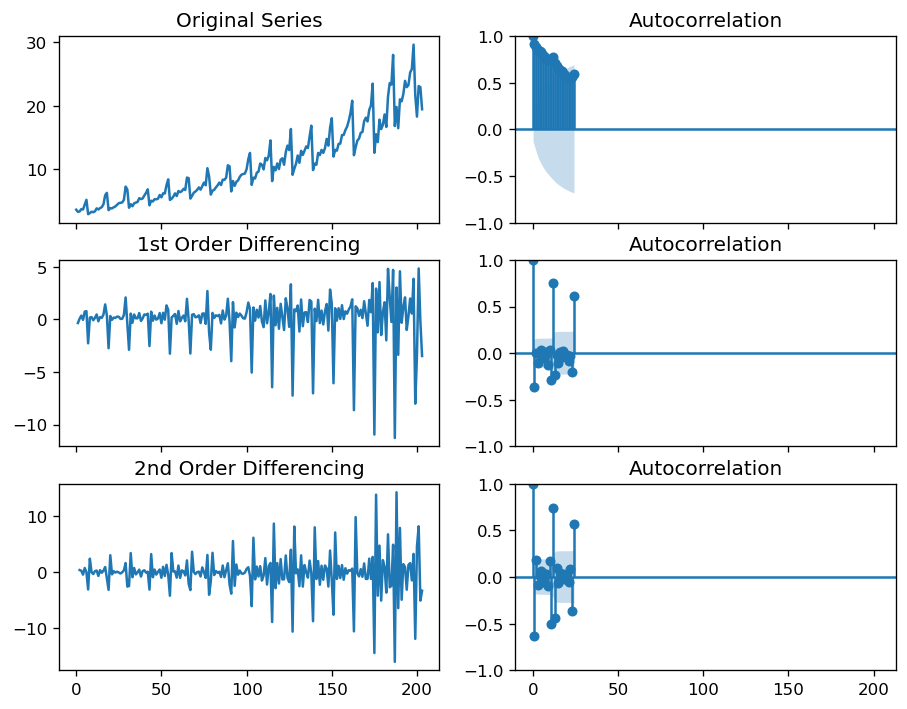

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

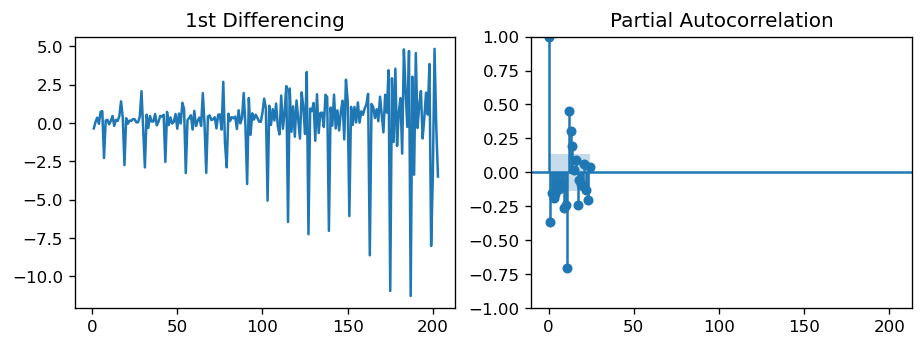

In [33]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()

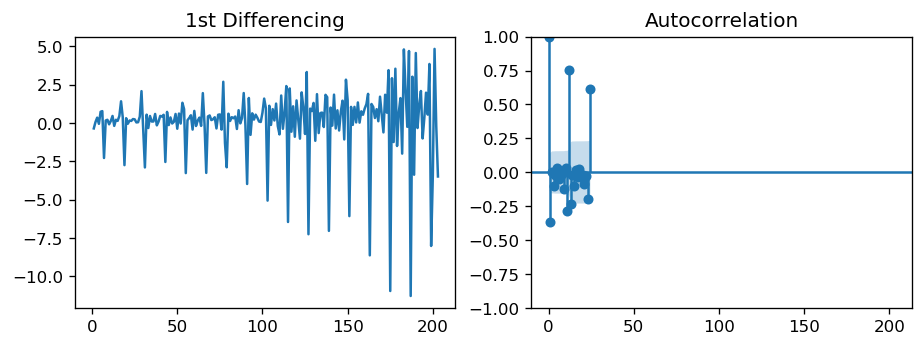

In [34]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

#### Splitting the data into training and testing sets

In [35]:
train_size = int(len(df) * 0.75)
train, test = data[:train_size], data[train_size:]
print('Observations: %d' % (len(data)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 204
Training Observations: 153
Testing Observations: 51


#### Fitting an ARIMA model to the training data

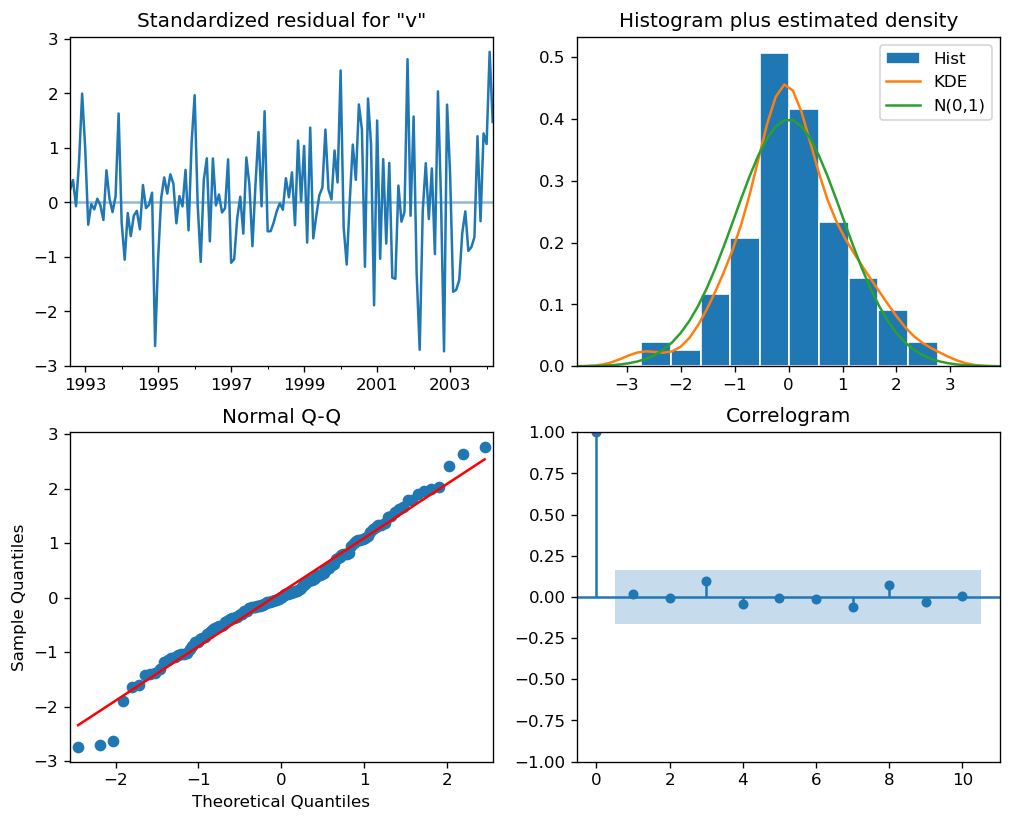

In [37]:
# Build Model
# model = ARIMA(train, order=(3, 2, 1))
model = ARIMA(train,  order=(2,1,3), seasonal_order=(1,1,3,12))
fitted = model.fit()

fitted.plot_diagnostics(figsize=(10,8))
plt.show()

### 4. Visualize the forecast against the actual data.

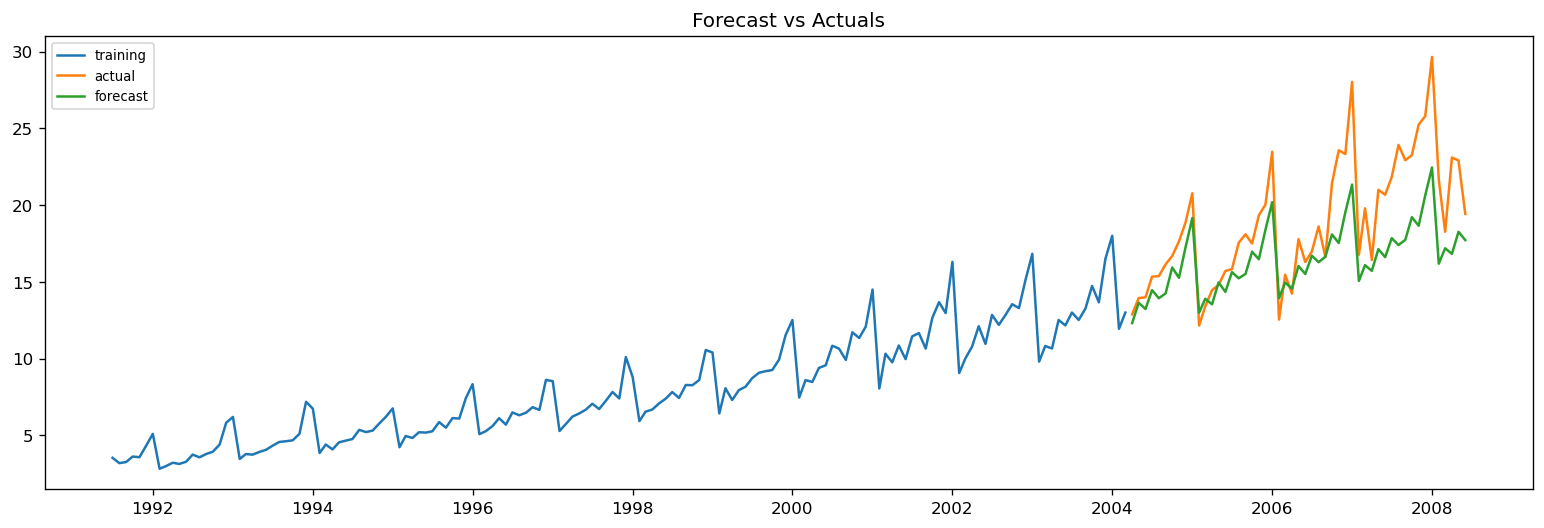

In [38]:
# Forecast
fc = fitted.forecast(steps=len(test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)

# Plot
plt.figure(figsize=(16,5), dpi=120)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series,
#                  color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()
